In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

slim = tf.contrib.slim
ds = tf.contrib.distributions

Populating the interactive namespace from numpy and matplotlib


/home/bruno/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [2]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [3]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-5,4,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [4]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=8000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
)

## Function for Symplectic gradient adjustment

In [ ]:
def hac_vec(ys,xs,vs):
    rett

## Construct model and training ops

In [8]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
# d_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
# Vanilla generator update
# g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)

## Train

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/8001 [00:00<?, ?it/s]

0


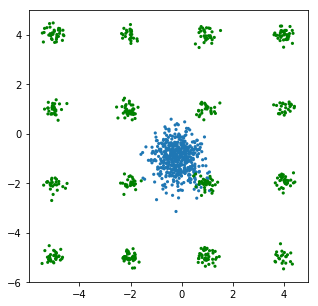

 25%|██▍       | 1999/8001 [02:40<08:00, 12.48it/s]

2000


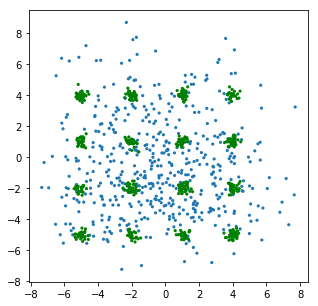

 50%|████▉     | 4000/8001 [05:31<05:32, 12.05it/s]

4000


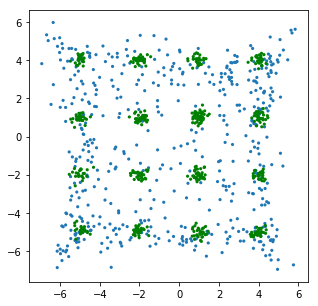

 52%|█████▏    | 4156/8001 [05:44<05:19, 12.05it/s]

In [ ]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
for i in tqdm(range(params['max_iter']+1)):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if (i) % viz_every == 0:
        print(i)
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         axis('off')
        show()